# MovieLens 1m Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens1m.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-1m/'  # if the files are local
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [4]:
df.shape

(1000209, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 6040
Number of items: 3706
Min item rating: 1
Max item rating: 5
Mean item rating: 3.581564453029317


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,My Fair Lady (1964),0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,Erin Brockovich (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [9]:
from CGT import get_baseline
?get_baseline

Signature: get_baseline(df, train_index, test_index, user_col, item_col)
Docstring:
Calculate baseline features from an explicit ratings dataset. Receives a dataframe
and returns train and test splits with added bias column and mean rating value.
User and item biases are calculated as average difference from global mean rating.
Baseline factors are only calculated from training observations, with users or
items that do not appear in train receiving the global average as default.

Args:
    df          : explicit ratings dataframe with columns userId, movieId and rating
    train_index : train index splits taken from KFold.splits()
    test_index  : test index splits taken from KFold.splits()
    
Returns:
    train, test : train/test splits of df, with added bias column
    global_mean : average rating of all training observations
File:      d:\myfiles\deep-collaborative-filtering\cgt.py
Type:      function


---
# CGT model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [10]:
from CGT import compile_genre_model
?compile_genre_model

Signature:
compile_genre_model(
    n_items,
    n_users,
    min_rating,
    max_rating,
    mean_rating,
    n_latent,
    n_hidden_1,
    n_hidden_2,
    activation='relu',
    dropout_1=0.2,
    dropout_2=0.2,
    random_seed=42,
)
Docstring: <no docstring>
File:      d:\myfiles\deep-collaborative-filtering\cgt.py
Type:      function


---
## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

## 1. Number of latent factors and hidden nodes

In [11]:
from sklearn.model_selection import KFold

In [12]:
bs1 = 2048
bs2 = 128

In [16]:
# hyper parameters
HP_N_FACTORS = [200, 1000]
HP_N_HIDDEN_2 = [[100], [200], [500]]

In [22]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_2 in HP_N_HIDDEN_2:

        print(f'Fitting CGT model #{searches} with {N_FACTORS} | {N_HIDDEN_2} architecture')
        searches += 1

        # Create 5 CV folds
        kf = KFold(n_splits=5, random_state=42)

        # initialise loss and epoch count
        total_loss = 0
        total_acc = 0
        count = 1
        min_epochs = 10

        # do CV split and compute baseline predictors each time
        for train_index, test_index in kf.split(movies):

            # get baseline rating predictors for full dataset
            train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

            # compile both models with search hparams
            model1, model2 = compile_genre_model(
                n_items=df.movieId.nunique(),
                n_users=df.userId.nunique(),
                min_rating=df.rating.min(),
                max_rating=df.rating.max(),
                mean_rating=df.rating.mean(),
                n_latent=N_FACTORS, 
                n_hidden_1=None,
                n_hidden_2=N_HIDDEN_2
            )

            # train rating model on all data
            ratings = model1.fit(
                x=[train.userId.values, train.movieId.values, train.bias.values],
                y=train.rating.values, 
                batch_size=bs1,
                epochs=6,
                verbose=0,
                validation_split=.2
            )

            # train genre model on 5 CV folds
            train = movies.iloc[train_index]
            test = movies.iloc[test_index]

            # train model on current fold
            result = model2.fit(
                train.movieId.values, train.Drama.values,
                batch_size=bs2, 
                epochs=4,
                verbose=0,
                validation_data=(test.movieId.values, test.Drama.values))

            # get loss from this fold
            fold_loss = result.history['val_loss'][-1]
            total_loss += fold_loss
            fold_acc = result.history['val_accuracy'][-1]
            total_acc += fold_acc

            count += 1

            del model1, model2

        # calculate average holdout loss across all CV folds
        avg_loss = total_loss / 5
        avg_acc = total_acc / 5
        print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
        print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

        grid_results.append({'n_factors':N_FACTORS,
                             'n_hidden_2':N_HIDDEN_2,
                             'val_loss':avg_loss,
                             'val_acc':avg_acc,
                             'train_loss_hist':result.history['loss'],
                             'val_loss_hist':result.history['val_loss'],
                             'train_acc_hist':result.history['accuracy'],
                             'val_acc_hist':result.history['val_accuracy']})

        print()
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 6 models

Fitting CGT model #1 with 200 | [100] architecture
_____________________________________CV avg val loss=0.5465
_____________________________________CV avg val acc=0.7133

Fitting CGT model #2 with 200 | [200] architecture
_____________________________________CV avg val loss=0.5332
_____________________________________CV avg val acc=0.7220

Fitting CGT model #3 with 200 | [500] architecture
_____________________________________CV avg val loss=0.5289
_____________________________________CV avg val acc=0.7187

Fitting CGT model #4 with 1000 | [100] architecture
_____________________________________CV avg val loss=0.5193
_____________________________________CV avg val acc=0.7241

Fitting CGT model #5 with 1000 | [200] architecture
_____________________________________CV avg val loss=0.5138
_____________________________________CV avg val acc=0.7262

Fitting CGT model #6 with 1000 | [500] architecture


KeyboardInterrupt: 

In [ ]:
# get best 5 models
grid_results = grid_results.sort_values('val_loss')
grid_results.to_csv(path+'grid_results.csv', index=False)

grid_results.head()

In [ ]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

In [ ]:
# plot training curve of best model
plt.plot(grid_results.train_loss_hist.values[0], label='train')
plt.plot(grid_results.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

In [ ]:
# train vs test accuracy
plt.plot(grid_results.train_acc_hist.values[0], label='train')
plt.plot(grid_results.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [ ]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors', 'n_hidden_2']]
best_rating_hparams

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='n_factors',
                y='val_loss',
#                 hue='n_hidden_2',
#                 size='n_hidden_2',
#                 palette='Set3',
                data=grid_results)

plt.title('Number of latent factors vs validation loss', fontsize=18)
plt.xlabel('Number of latent factors', fontsize=16)
plt.ylabel('Avg. CV loss', fontsize=16)
plt.savefig('figures/ml_1m_latent_factors.pdf', bbox_inches='tight')
# plt.legend(title='Hidden layer in genre model')
plt.show()

## 2. Dropout rate

In [27]:
# hyper parameters
HP_DROPOUT_2 = [.1, .15, .2, .25, .3]

In [28]:
# dataframe to store results of grid search
grid_results_3 = []
searches = 1

n_models = len(HP_DROPOUT_2)

print(f'Fitting total of {n_models} models\n')

for DROPOUT_2 in HP_DROPOUT_2:

    print(f'Fitting CGT model #{searches} with dr1: {DROPOUT_1} | dr2: {DROPOUT_2}')
    searches += 1

    # Create 5 CV folds
    kf = KFold(n_splits=5, random_state=42)

    # initialise loss and epoch count
    total_loss = 0
    total_acc = 0
    count = 1
    min_epochs = 10

    # do CV split and compute baseline predictors each time
    for train_index, test_index in kf.split(movies):

        # get baseline rating predictors for full dataset
        train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

        # compile both models with search hparams
        model1, model2 = compile_genre_model(
            n_items=df.movieId.nunique(),
            n_users=df.userId.nunique(),
            min_rating=df.rating.min(),
            max_rating=df.rating.max(),
            mean_rating=df.rating.mean(),
            n_latent=best_rating_hparams.n_factors, 
            n_hidden_1=None,
            n_hidden_2=best_rating_hparams.n_hidden_2,
            dropout_2=DROPOUT_2
        )

        # train rating model on all data
        ratings = model1.fit(
            x=[train.userId.values, train.movieId.values, train.bias.values],
            y=train.rating.values, 
            batch_size=bs1,
            epochs=6,
            verbose=0,
            validation_split=.2
        )

        # train genre model on 5 CV folds
        train = movies.iloc[train_index]
        test = movies.iloc[test_index]

        # train model on current fold
        result = model2.fit(
            train.movieId.values, train.Drama.values,
            batch_size=bs2, 
            epochs=4,
            verbose=0,
            validation_data=(test.movieId.values, test.Drama.values))

        # get loss from this fold
        fold_loss = result.history['val_loss'][-1]
        total_loss += fold_loss
        fold_acc = result.history['val_accuracy'][-1]
        total_acc += fold_acc

        count += 1

        del model1, model2

    # calculate average holdout loss across all CV folds
    avg_loss = total_loss / 5
    avg_acc = total_acc / 5
    print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
    print(f'_____________________________________CV avg val acc={avg_acc:.4f}')

    grid_results_3.append({'dropout_2':DROPOUT_2,
                           'val_loss':avg_loss,
                           'val_acc':avg_acc,
                           'train_loss_hist':result.history['loss'],
                           'val_loss_hist':result.history['val_loss'],
                           'train_acc_hist':result.history['accuracy'],
                           'val_acc_hist':result.history['val_accuracy']})

    print()
#             break
#         break
    
col_order = grid_results_3[0].keys()

# save results to data frame
grid_results_3 = pd.DataFrame(grid_results_3)
# reorder columns
grid_results_3 = grid_results_3[col_order]

Fitting total of 9 models

Fitting CGT model #1 with dr1: 0.15 | dr2: 0.15
_____________________________________CV avg val loss=0.5664
_____________________________________CV avg val acc=0.6969

Fitting CGT model #2 with dr1: 0.15 | dr2: 0.2
_____________________________________CV avg val loss=0.5665
_____________________________________CV avg val acc=0.6963

Fitting CGT model #3 with dr1: 0.15 | dr2: 0.25
_____________________________________CV avg val loss=0.5668
_____________________________________CV avg val acc=0.6981

Fitting CGT model #4 with dr1: 0.2 | dr2: 0.15
_____________________________________CV avg val loss=0.5712
_____________________________________CV avg val acc=0.6915

Fitting CGT model #5 with dr1: 0.2 | dr2: 0.2
_____________________________________CV avg val loss=0.5714
_____________________________________CV avg val acc=0.6912

Fitting CGT model #6 with dr1: 0.2 | dr2: 0.25
_____________________________________CV avg val loss=0.5715
______________________________

In [29]:
# get best 5 models
grid_results_3 = grid_results_3.sort_values('val_loss')
grid_results_3.to_csv(path+'grid_results_3.csv', index=False)

grid_results_3.head()

,dropout_1,dropout_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
0,0.15,0.15,0.566362,0.696852,"[0.6645117125947257, 0.6137002870060694, 0.587...","[0.637884573511098, 0.604546748090541, 0.58687...","[0.6285607, 0.67691153, 0.6930285, 0.70727134,...","[0.6551724, 0.66266865, 0.68215895, 0.70014995..."
1,0.15,0.20,0.566508,0.696252,"[0.6645956792752782, 0.6146208145271713, 0.588...","[0.6383739671428343, 0.6049560616756308, 0.587...","[0.6244378, 0.67391306, 0.69415295, 0.70689654...","[0.6551724, 0.66266865, 0.68065965, 0.6956522,..."
2,0.15,0.25,0.566764,0.698051,"[0.6655952825002942, 0.6153417920422876, 0.589...","[0.6393502367132607, 0.6057496363076492, 0.587...","[0.61806595, 0.6754123, 0.6934033, 0.7050225, ...","[0.6536732, 0.66266865, 0.6776612, 0.69415295,..."
6,0.25,0.15,0.569300,0.704948,"[0.6642720785098097, 0.6147861622798926, 0.591...","[0.6376128076077222, 0.6051754996158194, 0.588...","[0.6278111, 0.6791604, 0.68665665, 0.7050225, ...","[0.6431784, 0.6596702, 0.67616194, 0.6896552, ..."
7,0.25,0.20,0.569523,0.703748,"[0.6644458233684614, 0.6156729085334595, 0.592...","[0.6382043982731707, 0.6056152405231253, 0.589...","[0.6255622, 0.67653674, 0.68290854, 0.70464766...","[0.64467764, 0.6611694, 0.6716642, 0.68665665,..."


,dropout_1,dropout_2,val_loss,val_acc,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
0,0.15,0.15,0.566362,0.696852,"[0.6645117125947257, 0.6137002870060694, 0.587...","[0.637884573511098, 0.604546748090541, 0.58687...","[0.6285607, 0.67691153, 0.6930285, 0.70727134,...","[0.6551724, 0.66266865, 0.68215895, 0.70014995..."
1,0.15,0.20,0.566508,0.696252,"[0.6645956792752782, 0.6146208145271713, 0.588...","[0.6383739671428343, 0.6049560616756308, 0.587...","[0.6244378, 0.67391306, 0.69415295, 0.70689654...","[0.6551724, 0.66266865, 0.68065965, 0.6956522,..."
2,0.15,0.25,0.566764,0.698051,"[0.6655952825002942, 0.6153417920422876, 0.589...","[0.6393502367132607, 0.6057496363076492, 0.587...","[0.61806595, 0.6754123, 0.6934033, 0.7050225, ...","[0.6536732, 0.66266865, 0.6776612, 0.69415295,..."
6,0.25,0.15,0.569300,0.704948,"[0.6642720785098097, 0.6147861622798926, 0.591...","[0.6376128076077222, 0.6051754996158194, 0.588...","[0.6278111, 0.6791604, 0.68665665, 0.7050225, ...","[0.6431784, 0.6596702, 0.67616194, 0.6896552, ..."
7,0.25,0.20,0.569523,0.703748,"[0.6644458233684614, 0.6156729085334595, 0.592...","[0.6382043982731707, 0.6056152405231253, 0.589...","[0.6255622, 0.67653674, 0.68290854, 0.70464766...","[0.64467764, 0.6611694, 0.6716642, 0.68665665,..."


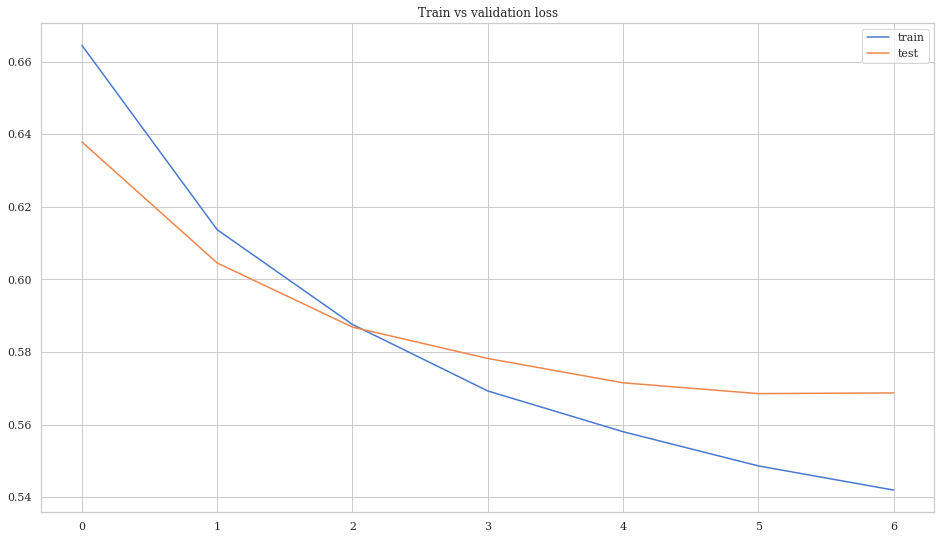

In [30]:
# plot training curve of best model
plt.plot(grid_results_3.train_loss_hist.values[0], label='train')
plt.plot(grid_results_3.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

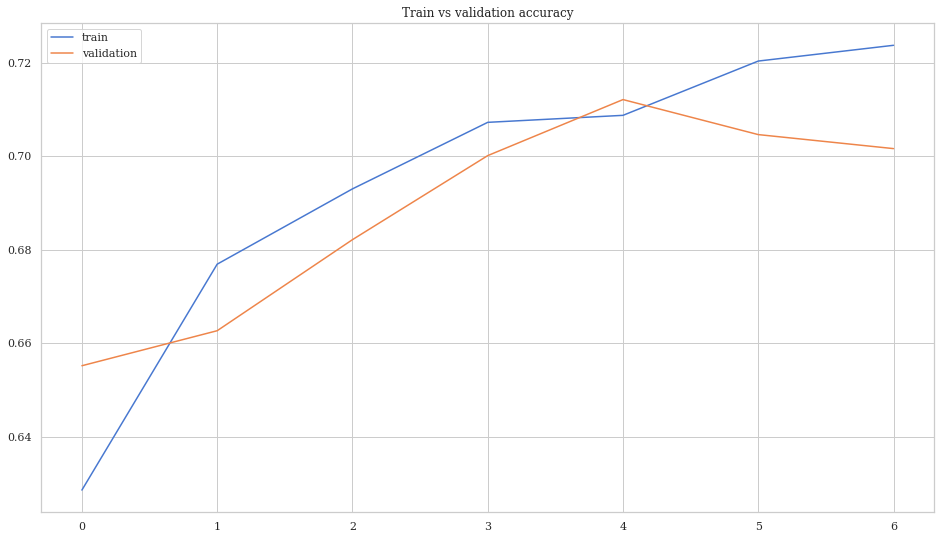

In [31]:
# train vs test accuracy
plt.plot(grid_results_3.train_acc_hist.values[0], label='train')
plt.plot(grid_results_3.val_acc_hist.values[0], label='validation')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [32]:
best_rating_hparams = pd.concat((best_rating_hparams, grid_results_3.iloc[0,:][['dropout_2']]))
best_rating_hparams

n_factors      200
n_hidden_1     100
n_hidden_2     100
epoch_1          8
epoch_2          7
dropout_1     0.15
dropout_2     0.15
dtype: object

# Classification report

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [34]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index, 'userId', 'movieId')

# compile both models
model1, model2 = compile_genre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=None,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_2=best_rating_hparams.dropout_2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=bs1,
    epochs=6,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=bs2, 
    epochs=4,
    validation_split=.2
)

Train on 800167 samples, validate on 200042 samples
Epoch 1/8
800167/800167 [==============================] - 18s 22us/sample - loss: 0.8195 - val_loss: 0.8708
Epoch 2/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.7737 - val_loss: 0.8735
Epoch 3/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.7443 - val_loss: 0.8798
Epoch 4/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.7145 - val_loss: 0.8860
Epoch 5/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6845 - val_loss: 0.8919
Epoch 6/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6557 - val_loss: 0.8939
Epoch 7/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6301 - val_loss: 0.8935
Epoch 8/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6070 - val_loss: 0.9023
Train on 2668 samples, validate on 667 samples
Epoch 1/7
2668/2668 [========

### Evaluate on test set

In [35]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       227
           1       0.61      0.61      0.61       144

    accuracy                           0.70       371
   macro avg       0.68      0.68      0.68       371
weighted avg       0.70      0.70      0.70       371



In [37]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,170,57
1,56,88


,0,1
0,170,57
1,56,88


In [38]:
# add predictions as column
movies_holdout['prediction'] = y_pred.values
# save to csv
movies_holdout[['movieId', 'title', 'Drama', 'prediction']].to_csv(path+'holdout_predictions.csv', index=False)

In [39]:
X_train = movies.movieId.values
y_train = movies.Drama.values
train_score = pd.DataFrame(model2.predict(X_train))
train_pred = train_score.round().astype('int')

In [40]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1986
           1       0.67      0.62      0.64      1349

    accuracy                           0.72      3335
   macro avg       0.71      0.71      0.71      3335
weighted avg       0.72      0.72      0.72      3335



In [41]:
pd.DataFrame(confusion_matrix(y_train, train_pred))

,0,1
0,1570,416
1,513,836


,0,1
0,1570,416
1,513,836


In [42]:
# add predictions as column
movies['prediction'] = train_pred.values
# save to csv
movies[['movieId', 'title', 'Drama', 'prediction']].to_csv(path+'train_predictions.csv', index=False)

---
# Appendix A: multi-label genre model

In [43]:
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,prediction
194,194,Unforgiven (1992),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1417,1417,"Blue Lagoon, The (1980)",0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2459,2459,Night Falls on Manhattan (1997),0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2293,2293,Under Siege 2: Dark Territory (1995),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3251,3251,Best Laid Plans (1999),0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,prediction
194,194,Unforgiven (1992),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1417,1417,"Blue Lagoon, The (1980)",0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2459,2459,Night Falls on Manhattan (1997),0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2293,2293,Under Siege 2: Dark Territory (1995),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3251,3251,Best Laid Plans (1999),0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [44]:
movies.shape

(3335, 21)

In [45]:
from CGT import compile_multigenre_model

In [46]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_multigenre_model(
    n_items=df.movieId.nunique(),
    n_users=df.userId.nunique(),
    min_rating=df.rating.min(),
    max_rating=df.rating.max(),
    mean_rating=df.rating.mean(),
    n_genres=18,
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2,
    dropout_1=best_rating_hparams.dropout_1,
    dropout_2=best_rating_hparams.dropout_2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=bs1,
    epochs=best_rating_hparams.epoch_1,
    verbose=1,
    validation_split=.2
)

Train on 800167 samples, validate on 200042 samples
Epoch 1/8
800167/800167 [==============================] - 17s 22us/sample - loss: 0.8195 - val_loss: 0.8708
Epoch 2/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.7737 - val_loss: 0.8735
Epoch 3/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.7443 - val_loss: 0.8798
Epoch 4/8
800167/800167 [==============================] - 18s 22us/sample - loss: 0.7145 - val_loss: 0.8860
Epoch 5/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6845 - val_loss: 0.8919
Epoch 6/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6557 - val_loss: 0.8939
Epoch 7/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6301 - val_loss: 0.8935
Epoch 8/8
800167/800167 [==============================] - 17s 21us/sample - loss: 0.6070 - val_loss: 0.9023


In [47]:
# train genre model
genres = model2.fit(
    movies.movieId.values, movies.iloc[:,-19:-1].values,  # multi label
    batch_size=bs2, 
    epochs=best_rating_hparams.epoch_2,
    validation_split=.2)

Train on 2668 samples, validate on 667 samples
Epoch 1/7
2668/2668 [==============================] - 1s 306us/sample - loss: 0.6662 - accuracy: 0.7026 - AUC: 0.6364 - val_loss: 0.6295 - val_accuracy: 0.8676 - val_AUC: 0.6871
Epoch 2/7
2668/2668 [==============================] - 0s 80us/sample - loss: 0.5835 - accuracy: 0.8914 - AUC: 0.7023 - val_loss: 0.5322 - val_accuracy: 0.8981 - val_AUC: 0.6955
Epoch 3/7
2668/2668 [==============================] - 0s 85us/sample - loss: 0.4749 - accuracy: 0.9073 - AUC: 0.7031 - val_loss: 0.4196 - val_accuracy: 0.9045 - val_AUC: 0.6911
Epoch 4/7
2668/2668 [==============================] - 0s 90us/sample - loss: 0.3747 - accuracy: 0.9111 - AUC: 0.7064 - val_loss: 0.3396 - val_accuracy: 0.9060 - val_AUC: 0.7031
Epoch 5/7
2668/2668 [==============================] - 0s 90us/sample - loss: 0.3150 - accuracy: 0.9118 - AUC: 0.7247 - val_loss: 0.2988 - val_accuracy: 0.9061 - val_AUC: 0.7273
Epoch 6/7
2668/2668 [==============================] - 0s 91us

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [49]:
y_true = movies.iloc[:,-19:-1]
y_score = pd.DataFrame(model2.predict(movies.movieId.values), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [50]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       448
   Adventure       0.00      0.00      0.00       256
   Animation       0.00      0.00      0.00        92
  Children's       0.00      0.00      0.00       224
      Comedy       0.00      0.00      0.00      1047
       Crime       0.00      0.00      0.00       184
 Documentary       0.00      0.00      0.00        97
       Drama       0.60      0.64      0.62      1349
     Fantasy       0.00      0.00      0.00        62
   Film-Noir       0.00      0.00      0.00        43
      Horror       0.00      0.00      0.00       303
     Musical       0.00      0.00      0.00       100
     Mystery       0.00      0.00      0.00        94
     Romance       0.00      0.00      0.00       416
      Sci-Fi       0.00      0.00      0.00       249
    Thriller       0.00      0.00      0.00       434
         War       0.00      0.00      0.00       126
     Western       0.00    